In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl

In [2]:
# clrs = sns.color_palette('Set1')
# clrs[5] = (255/255, 200/255, 80/255)
# colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
# #mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 150

# Convenience Functions

In [4]:
def radial_velocity(wavelengths, labline):
    velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
    return velocity

def gaussian(x, amp, sig, cen, bgl):
    x = np.array(x)
    y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
    return y

In [5]:
def make_gauss_from_params(x, params):
    if len(params) == 4:
        return gaussian(x, params['amp'][0], params['sig'][0], params['cen'][0], params['bgl'][0])
    if len(params) == 7:
        return [gaussian(x, params['amp1'][0], params['sig1'][0], params['cen1'][0], params['bgl'][0]), gaussian(x, params['amp2'][0], params['sig2'][0], params['cen2'][0], params['bgl'][0])]

# Read in Data

In [6]:
line_df = pd.read_pickle(os.path.join('data', 'line_df_coadded.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_df_coadded.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_df_coadded.pkl'))

In [6]:
line_df = pd.read_pickle(os.path.join('data', 'line_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_df.pkl'))

prog_df = pd.read_pickle(os.path.join('data', 'line_prog_df_local.pkl'))
blue_prog_df = pd.read_pickle(os.path.join('data', 'blue_prog_df.pkl'))
red_prog_df = pd.read_pickle(os.path.join('data', 'red_prog_df.pkl'))

In [7]:
def SNR(signal, noise):
    #normalize the signal
    normsignal = signal/np.max(signal)
    normnoise = noise/np.max(noise)
    return np.mean(normsignal/normnoise)

def snr_mask(df, low, high):
    ratio = df.apply(lambda r: SNR(r['gauss_flux'], r['gauss_fluxerr']) /
                               SNR(r['flux'], r['fluxerr']), axis=1)
    return df[ratio.between(low, high)]

red_df_cut  = snr_mask(red_df,  1.3, 13)
blue_df_cut = snr_mask(blue_df, 1.3, 16)
line_df_cut = snr_mask(line_df, 0.8, 100)

In [8]:
def peak_mask(df, thresh):
    ratio = df.apply(lambda r: max(r['gauss_flux'].value)/r['params1']['bgl'][0], axis=1)
    mask = np.array(ratio) > thresh
    return ratio, df[mask].copy()

red_df_ratio, red_df_peak  = peak_mask(red_df_cut,  1.5)
blue_df_ratio, blue_df_peak = peak_mask(blue_df_cut, 1.5)
line_df_ratio, line_df_peak = peak_mask(line_df_cut, 1.5)

In [8]:
print(len(red_df), len(red_df_cut), len(red_df_peak))
print(len(blue_df), len(blue_df_cut), len(blue_df_peak))

12 10 9
7 7 7


# Plot All fits

In [9]:
line_mask_dict = {
    1453.1:200,
    1555.89:[75,175],
    1463.83:200,
    1613.72:[75,200],
    1415.33:180,
    1407.29:200,
    1468.39:[75,299], #mask out MgII transition at 1466.55
    1407.29: [75,250],
    1435.05: [80,299], #High velocity component
    1636.34: [75,190]
}

def mask_contamination(labline, mask_dict):
    mask_idx = mask_dict[labline]
    if isinstance(mask_idx, list):
        mask=np.ones(300, dtype=bool)
        mask[mask_idx[0]:mask_idx[1]] = False
        return mask
    else:
        mask=np.zeros(300, dtype=bool)
        mask[mask_idx:] = True
        return mask

In [12]:
def plot_fits(df, transition, plot_vel=False):
    for _, row in df[df['transition']==transition].iterrows():
        flux = row['flux'].value
        fluxerr = row['fluxerr'].value
        wave = row['wavelength']#.value
        vel_data = radial_velocity(wave, row['labline']).value
        
        ygauss = row['gauss_flux'].value
        ygausserr = row['gauss_fluxerr'].value

        y2gauss = row['double_gauss_flux'].value
        y2gausserr = row['double_gauss_fluxerr'].value
        
        waveconv = row['conv_wavelength']#.value
        vel_conv = radial_velocity(waveconv, row['labline']).value

        fig, ax = plt.subplots(2,2, figsize = (9,5), sharex=True, gridspec_kw={'height_ratios':[3,1]}, layout='constrained')
        fig.subplots_adjust(hspace=0, wspace=0)
        if plot_vel:
            #data
            ax[0,0].plot(vel_data, flux, '--', label='emission line')
            ax[0,0].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='tab:blue', alpha=0.2)
            ax[0,1].plot(vel_data, flux, '--', label='emission line')
            ax[0,1].fill_between(vel_data, flux-fluxerr, flux+fluxerr, color='tab:blue', alpha=0.2)
            
            #fits
            ygauss1, ygauss2 = make_gauss_from_params(waveconv, row['params2'])

            ax[0,0].plot(vel_conv, ygauss, label='single conv gauss')
            ax[0,0].fill_between(vel_conv, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0,1].plot(vel_conv, ygauss1, label='1')
            ax[0,1].plot(vel_conv, ygauss2, label='2')

            ax[0,0].set_title(f"BIC = {row['BIC1']}")
            ax[0,1].set_title(f"BIC = {row['BIC2']}")

            ax[0,1].plot(vel_conv, y2gauss, label='double conv gauss')
            ax[0,1].fill_between(vel_conv, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)

            #residuals
            if row['labline'] in line_mask_dict:
                mask = mask_contamination(row['labline'], line_mask_dict)
                masked_flux = flux[~mask]
                masked_fluxerr = fluxerr[~mask]
            else:
                masked_flux = flux
                masked_fluxerr = fluxerr

            ax[1,0].errorbar(vel_conv, ygauss-masked_flux, yerr=masked_fluxerr, ms=5, lw=0, marker='.', elinewidth=0.3)
            ax[1,0].hlines(0, min(vel_conv), max(vel_conv), 'r', '--')
            ax[1,1].errorbar(vel_conv, y2gauss-masked_flux, yerr=masked_fluxerr, ms=5, lw=0, marker='.', elinewidth=0.3)
            ax[1,1].hlines(0, min(vel_conv), max(vel_conv), 'r', '--')

            for i, param in enumerate(row['params2']):
                ax[0,1].text(0.05, 0.95-(i*0.05), f"{param} = {row['params2'][param][0]:.2e}",
                                transform=ax[0,1].transAxes, verticalalignment='top')
            
            for i, param in enumerate(row['params1']):
                ax[0,0].text(0.05, 0.95-(i*0.05), f"{param} = {row['params1'][param][0]:.2e}",
                                transform=ax[0,0].transAxes, verticalalignment='top')

            fig.supxlabel(r'Velocity (m s$^{-1}$)')
        else:
            #data
            ax[0,0].plot(wave.value, flux, '--', label='emission line')
            ax[0,0].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='tab:blue', alpha=0.2)
            ax[0,1].plot(wave.value, flux, '--', label='emission line')
            ax[0,1].fill_between(wave.value, flux-fluxerr, flux+fluxerr, color='tab:blue', alpha=0.2)

            #fits
            ygauss1, ygauss2 = make_gauss_from_params(wave, row['params2'])

            ax[0,0].plot(waveconv.value, ygauss, label='single conv gauss')
            ax[0,0].fill_between(waveconv.value, ygauss-ygausserr, ygauss+ygausserr, color='red', alpha=0.4,)

            ax[0,1].plot(wave, ygauss1, label='1')
            ax[0,1].plot(wave, ygauss2, label='2')

            ax[0,0].set_title(f"BIC = {row['BIC1']}")
            ax[0,1].set_title(f"BIC = {row['BIC2']}")

            ax[0,1].plot(waveconv.value, y2gauss, label='double conv gauss')
            ax[0,1].fill_between(waveconv.value, y2gauss-y2gausserr, y2gauss+y2gausserr, color='red', alpha=0.4,)

            #residuals
            if row['labline'] in line_mask_dict:
                mask = mask_contamination(row['labline'], line_mask_dict)
                masked_flux = flux[~mask]
                masked_fluxerr = fluxerr[~mask]
            else:
                masked_flux = flux
                masked_fluxerr = fluxerr

            ax[1,0].errorbar(waveconv.value, ygauss-masked_flux, yerr=masked_fluxerr, ms=5, lw=0, marker='.', elinewidth=0.3)
            ax[1,0].hlines(0, min(waveconv.value), max(waveconv.value), 'r', '--')
            ax[1,1].errorbar(waveconv.value, y2gauss-masked_flux, yerr=masked_fluxerr, ms=5, lw=0, marker='.', elinewidth=0.3)
            ax[1,1].hlines(0, min(waveconv.value), max(waveconv.value), 'r', '--')

            for i, param in enumerate(row['params2']):
                ax[0,1].text(0.05, 0.95-(i*0.05), f"{param} = {row['params2'][param][0]:.2e}",
                                transform=ax[0,1].transAxes, verticalalignment='top')
            
            for i, param in enumerate(row['params1']):
                ax[0,0].text(0.05, 0.95-(i*0.05), f"{param} = {row['params1'][param][0]:.2e}",
                                transform=ax[0,0].transAxes, verticalalignment='top')

            fig.supxlabel(r'Wavelength ($\AA$)')
            
        ax[0,0].legend()
        ax[0,1].legend()
        fig.supylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
        fig.suptitle(f"{row['transition']} {row['labline']} {row['obsdate']}")
        ax[1,0].set_ylim(-1e-13,1e-13)
        ax[1,1].set_ylim(-1e-13,1e-13)
        
        ax[0,0].set_ylim(0,1e-12)
        ax[0,1].set_ylim(0,1e-12)
        plt.show()

In [115]:
vsini = ((0.01/1431.01) * const.c.to(u.km/u.s)) #v sini
vsini/np.sin(19)

<Quantity 13.97791629 km / s>

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


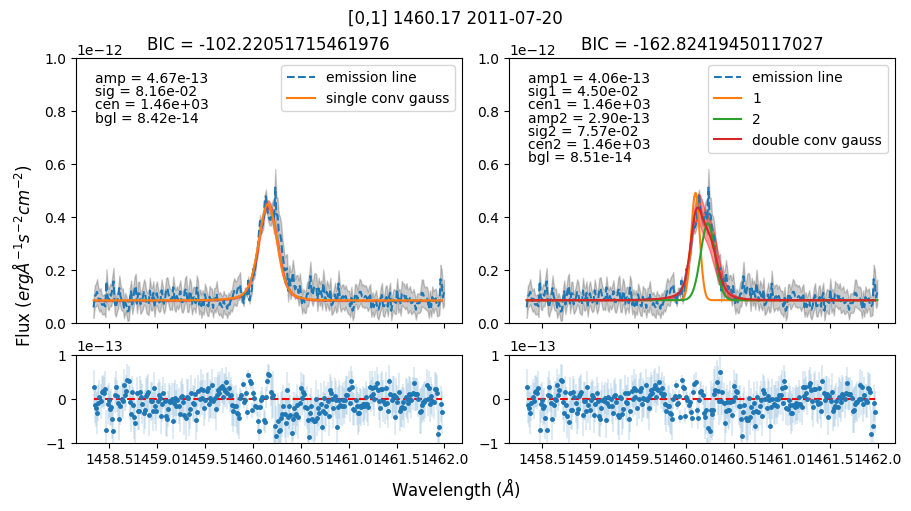

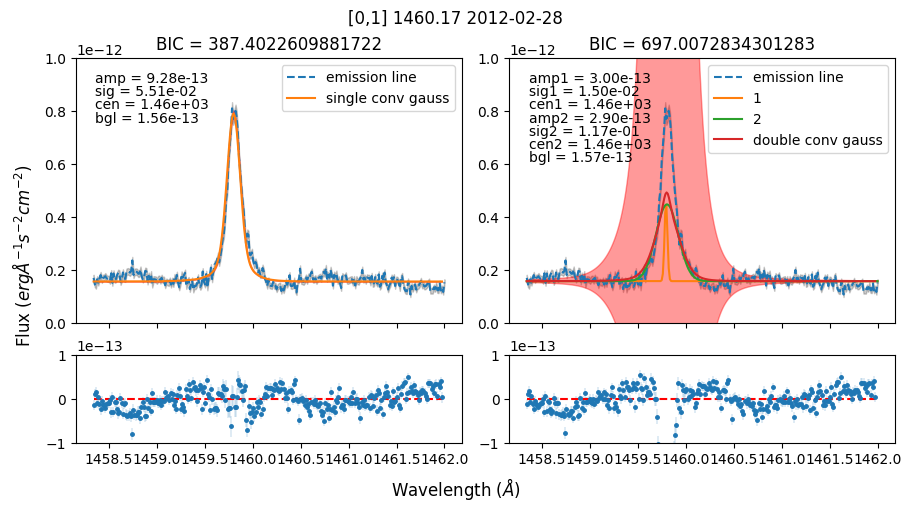

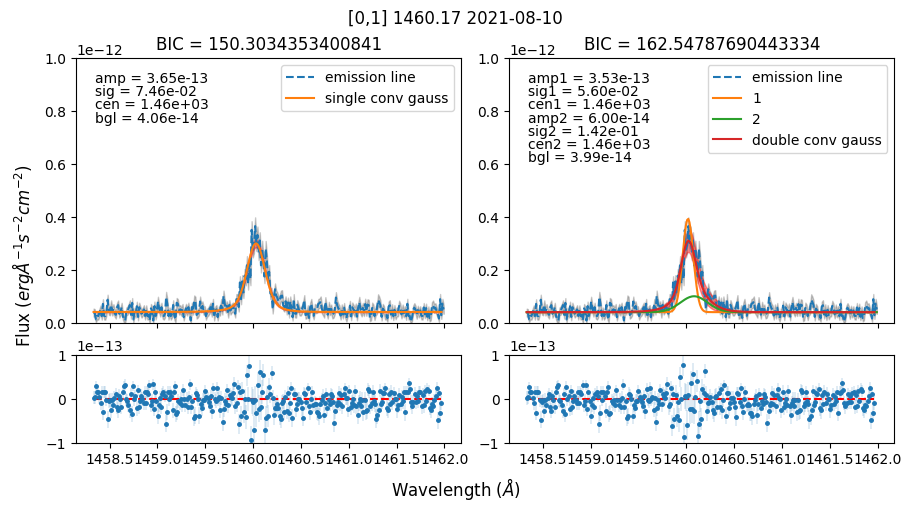

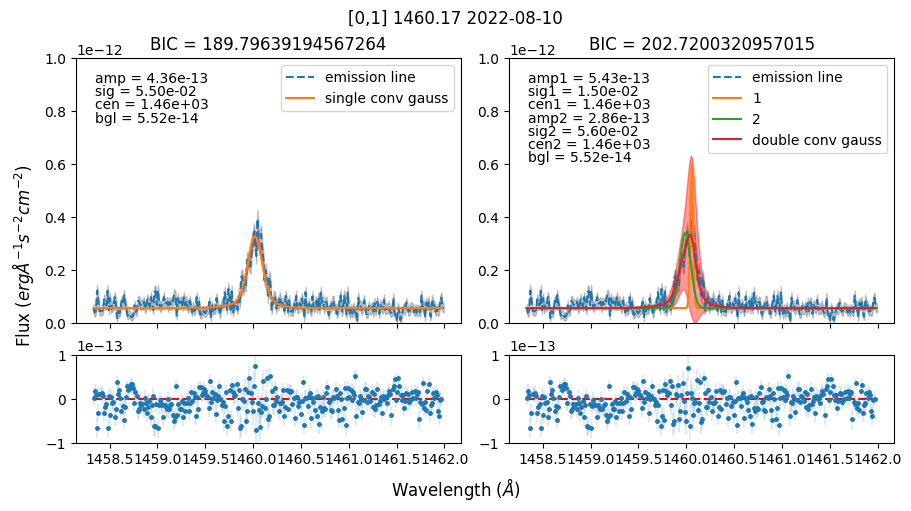

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


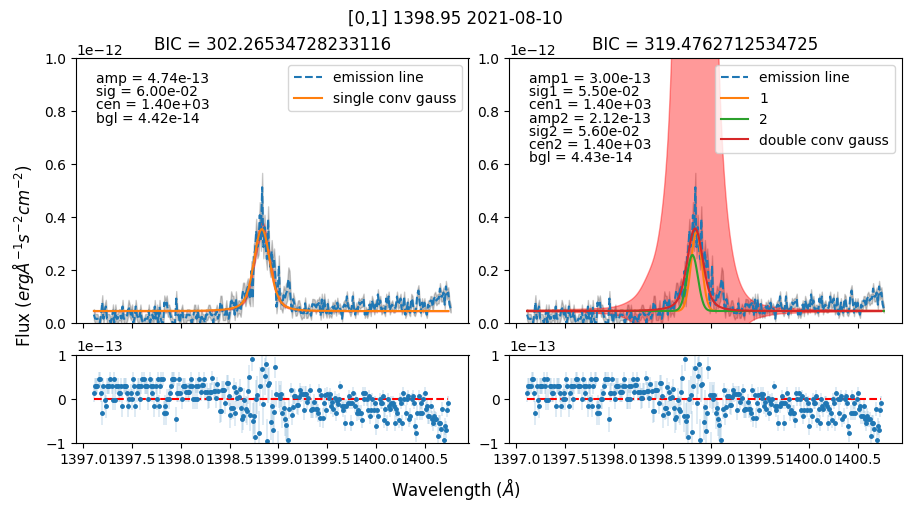

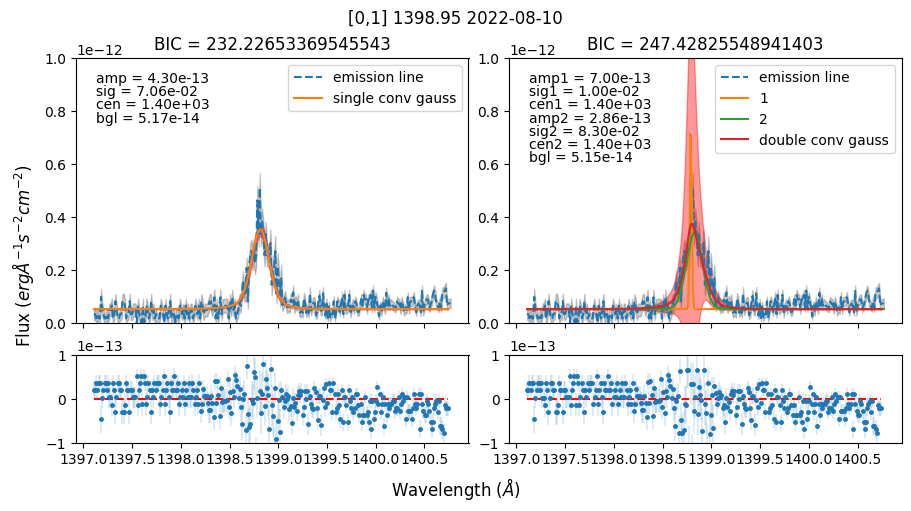

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


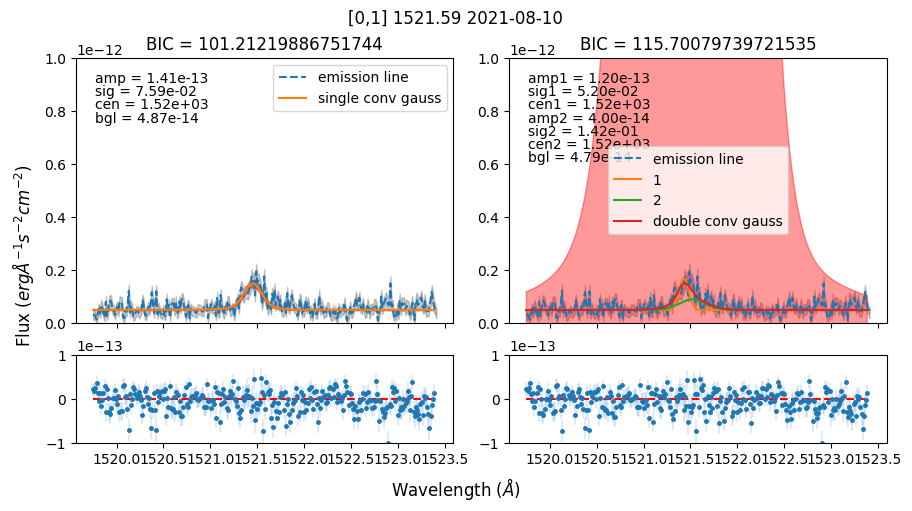

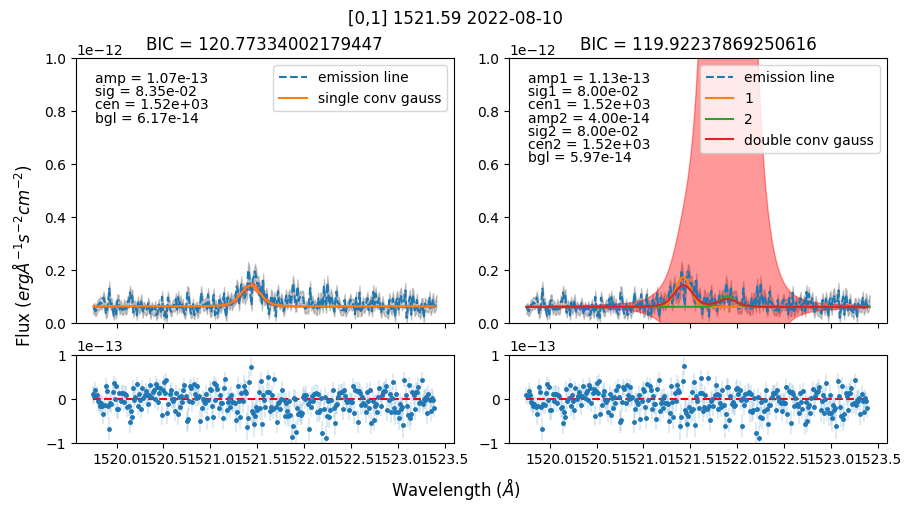

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


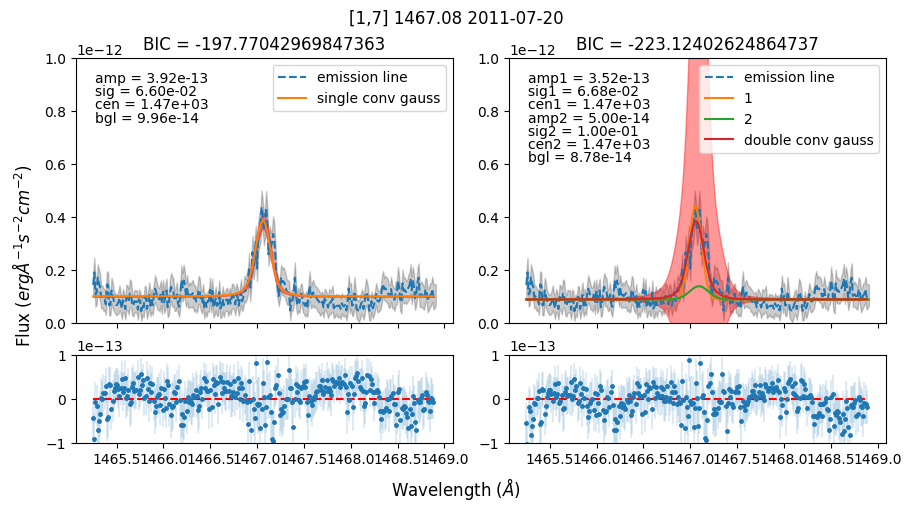

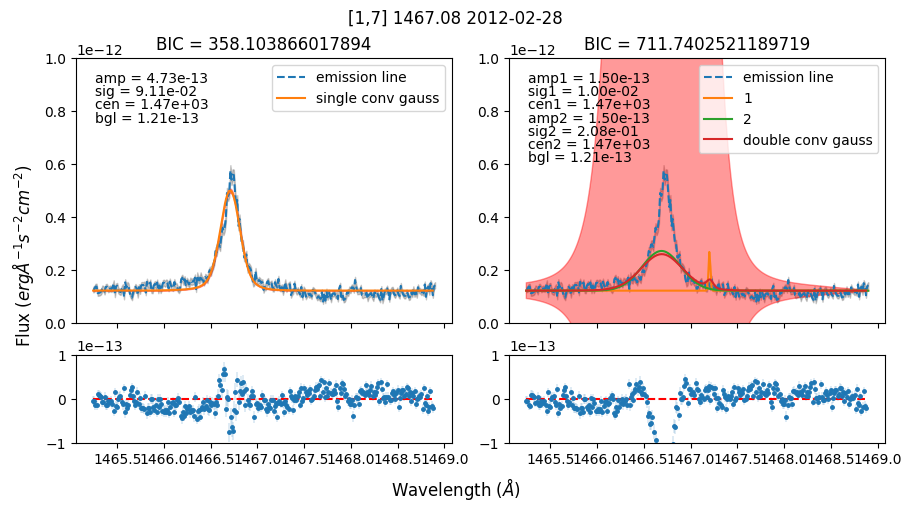

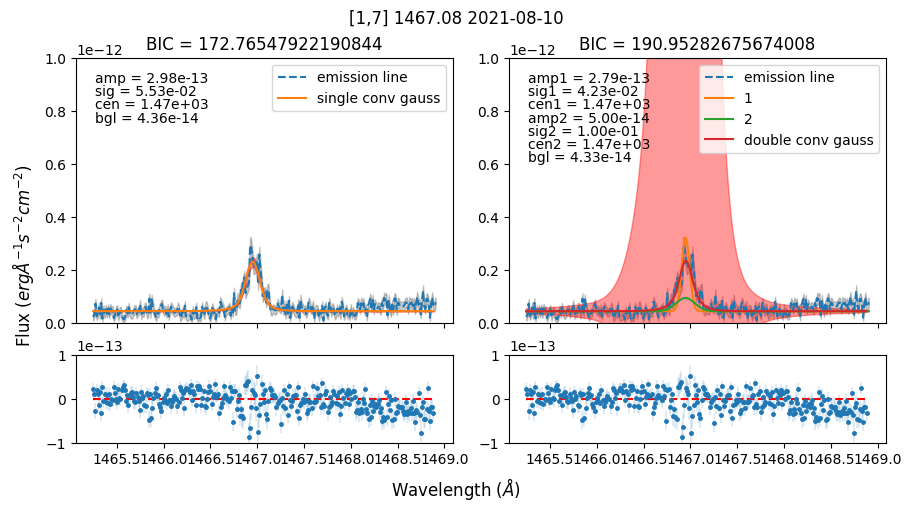

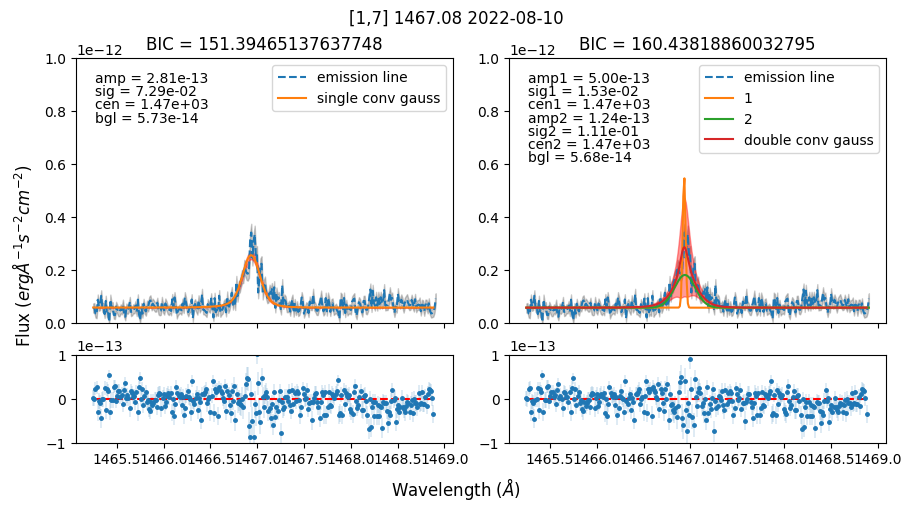

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


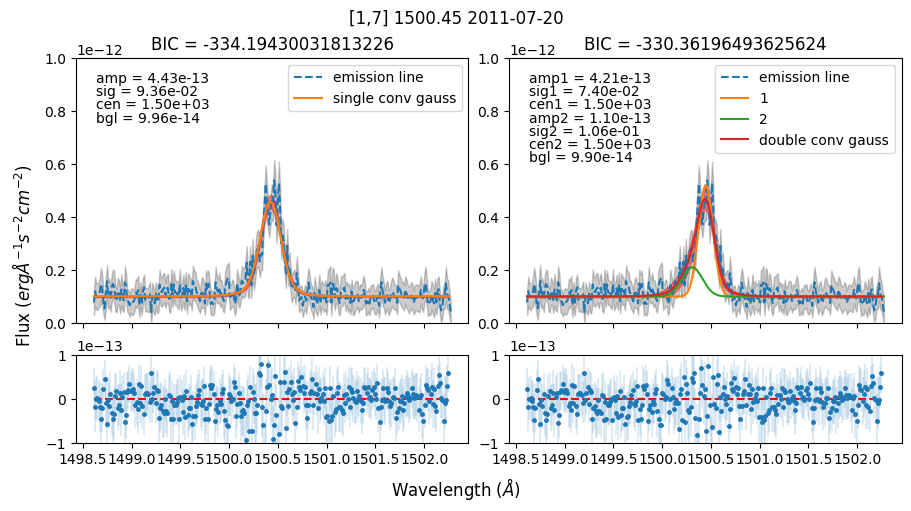

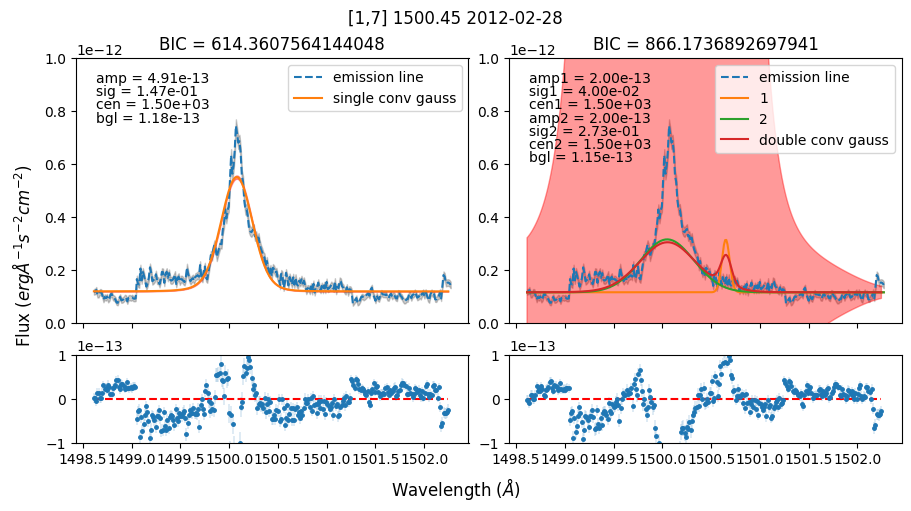

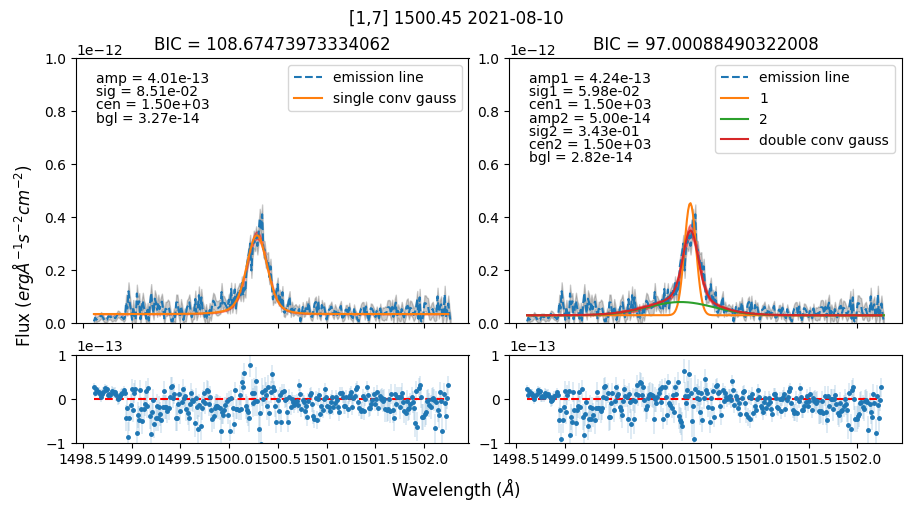

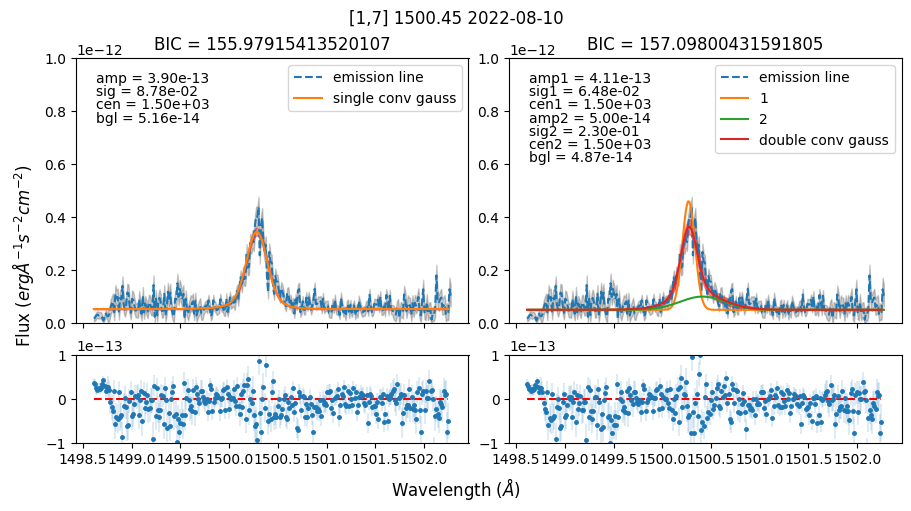

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


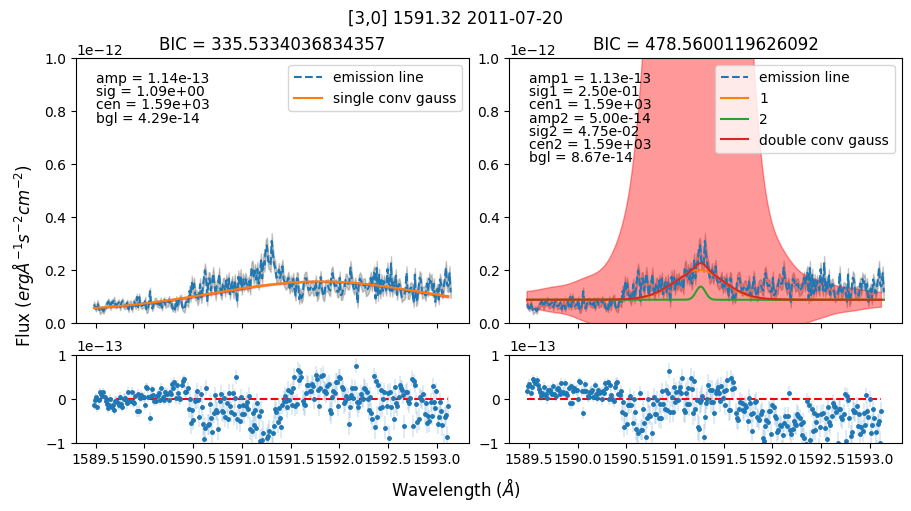

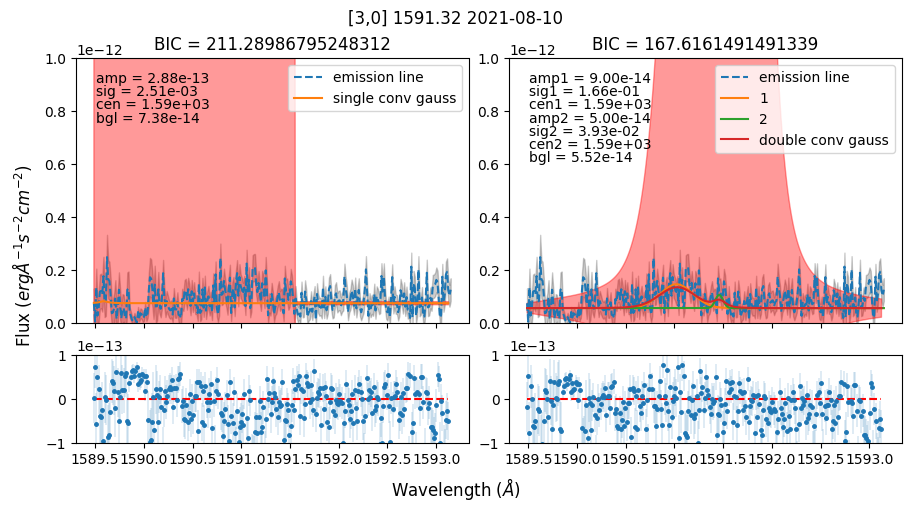

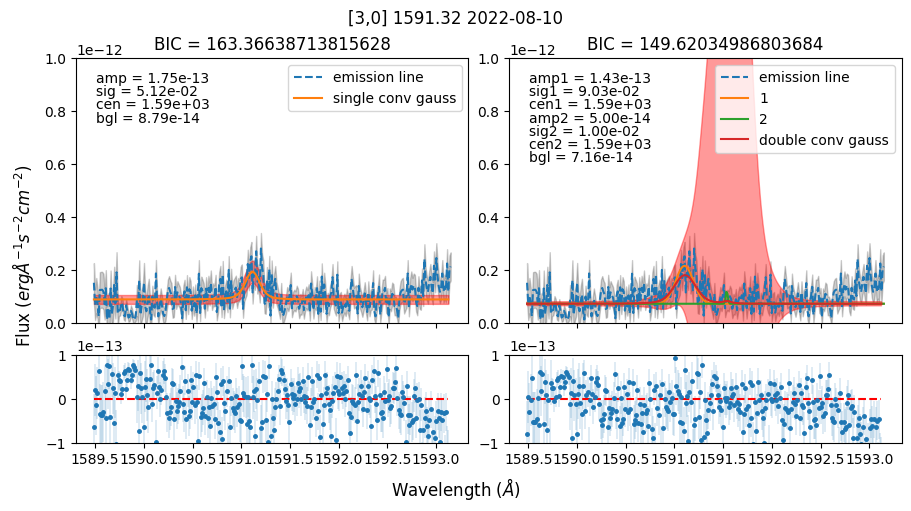

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


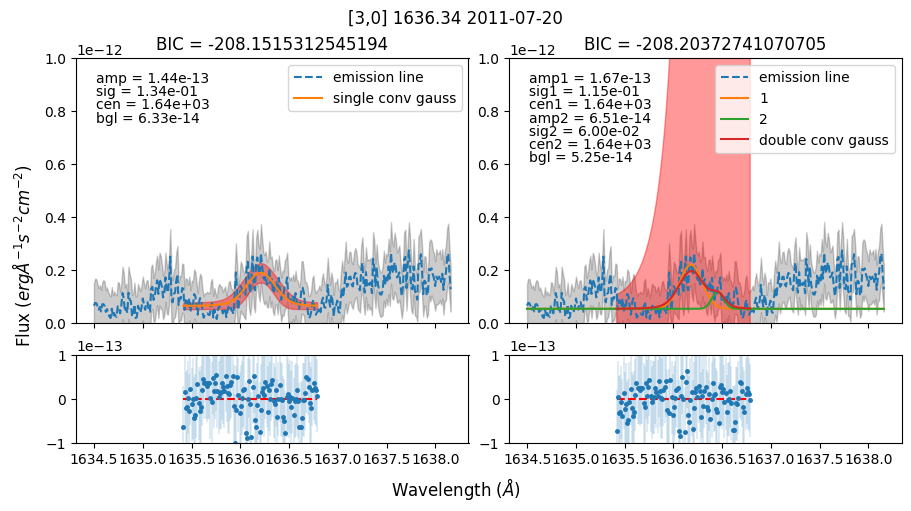

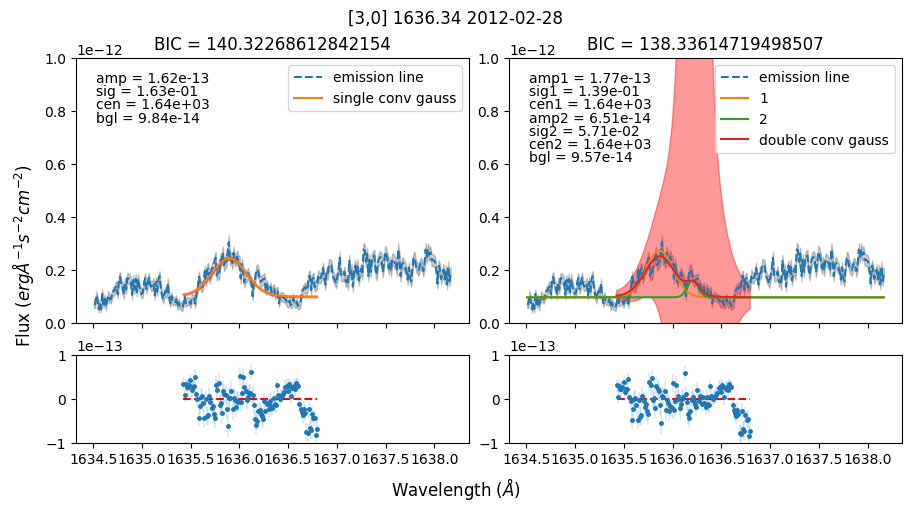

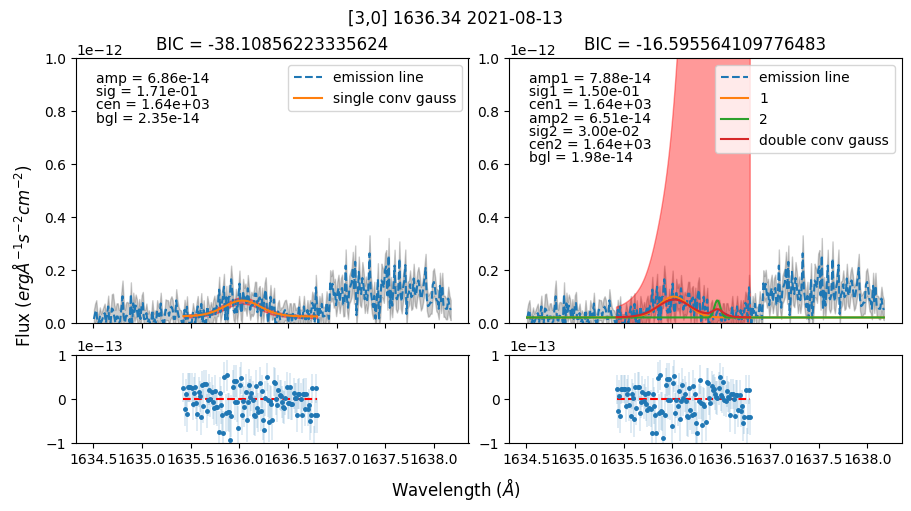

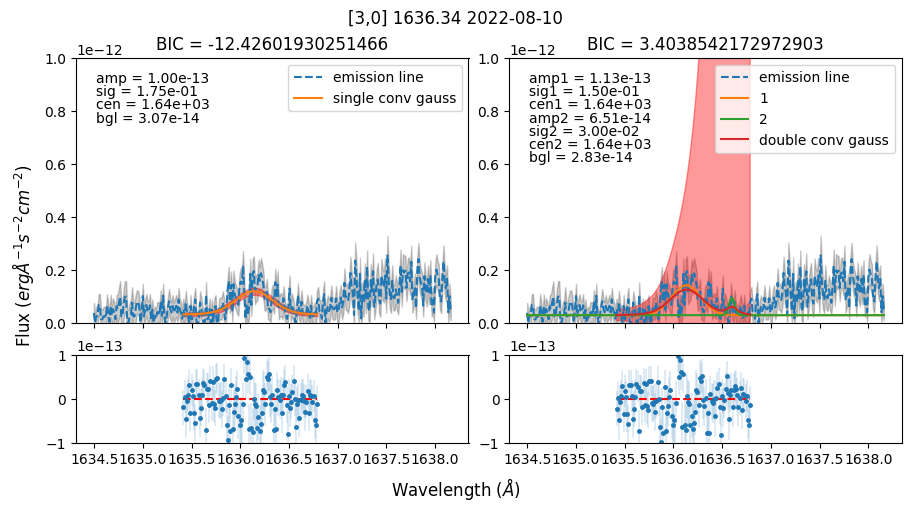

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


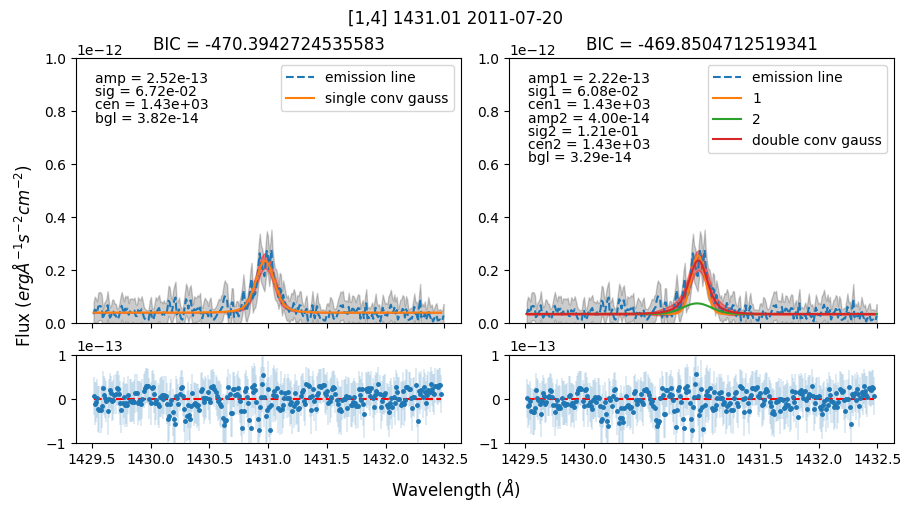

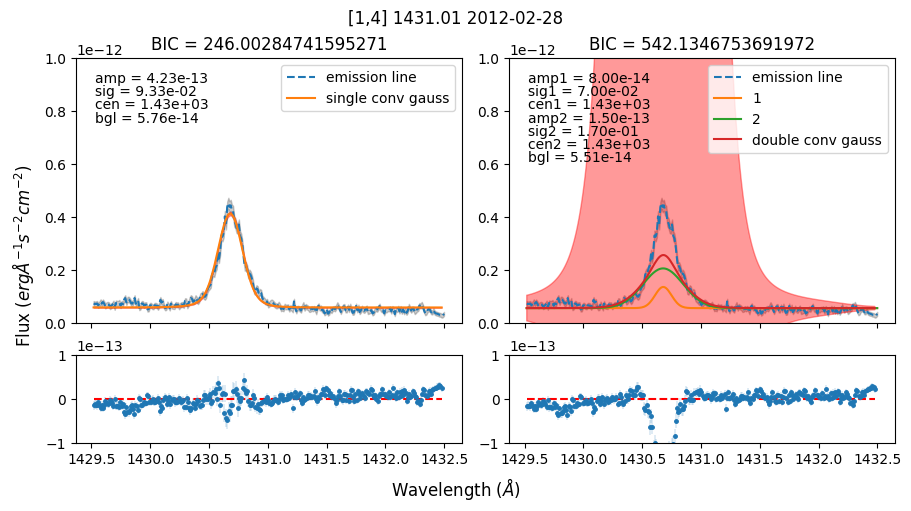

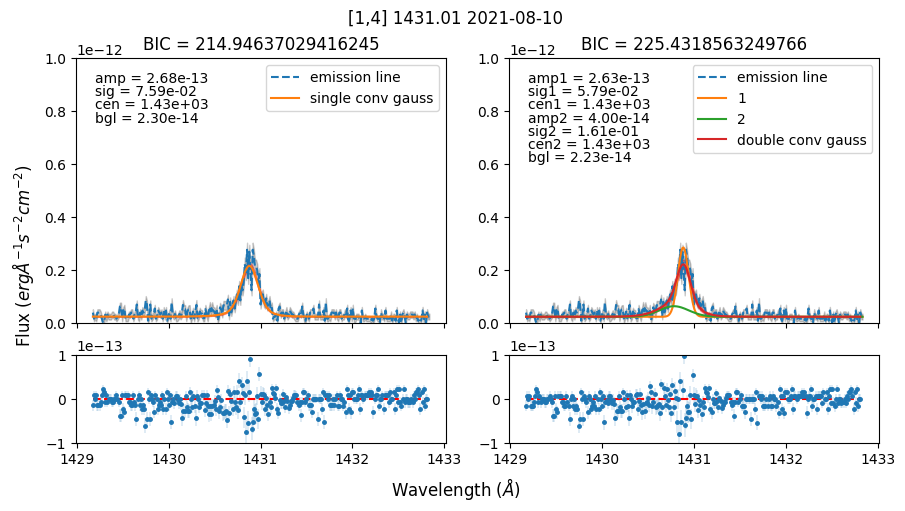

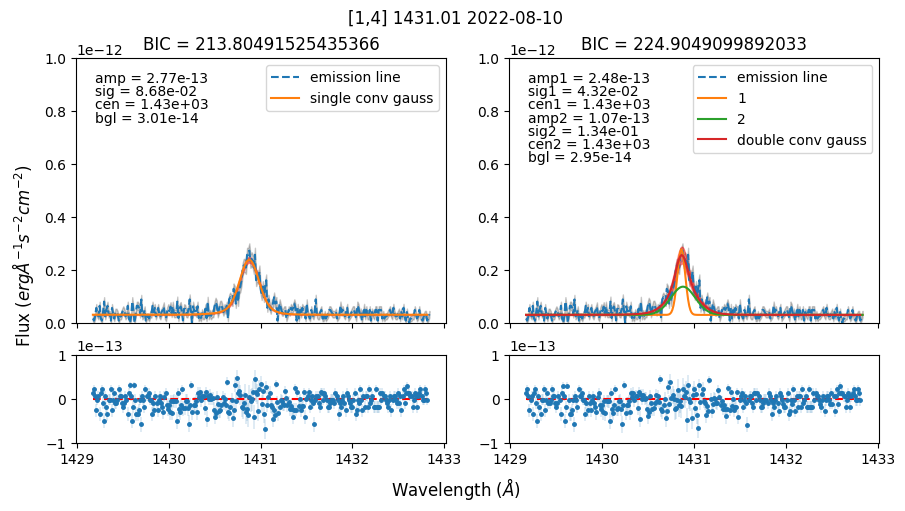

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


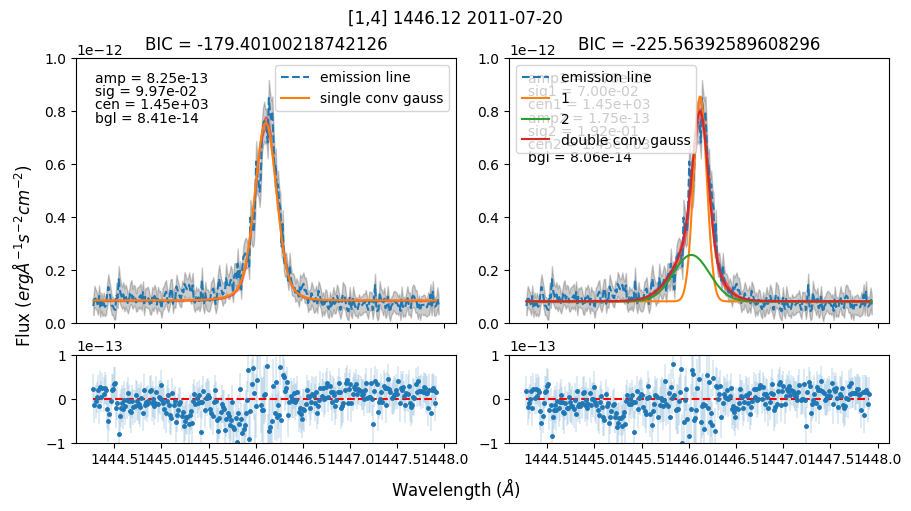

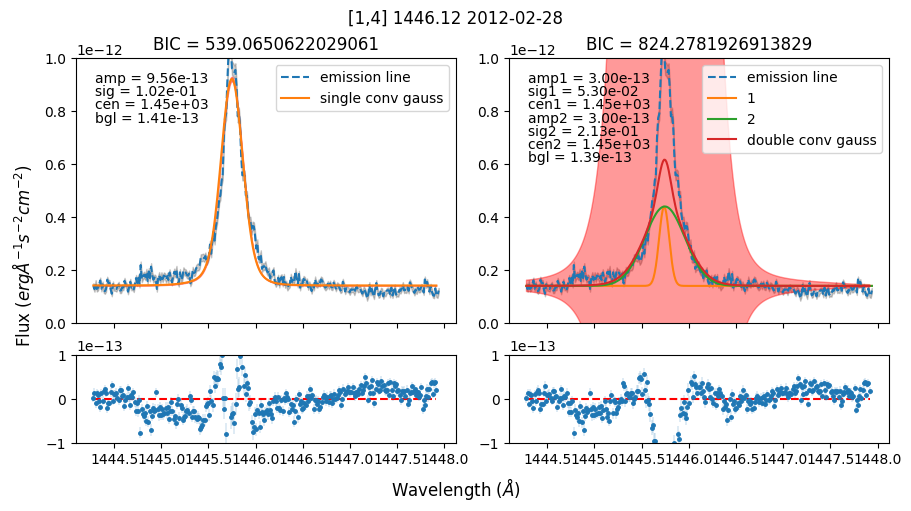

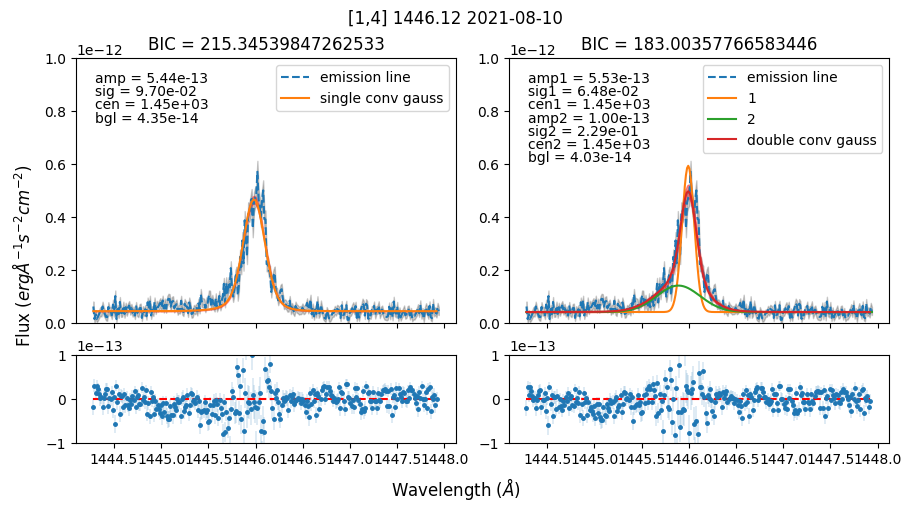

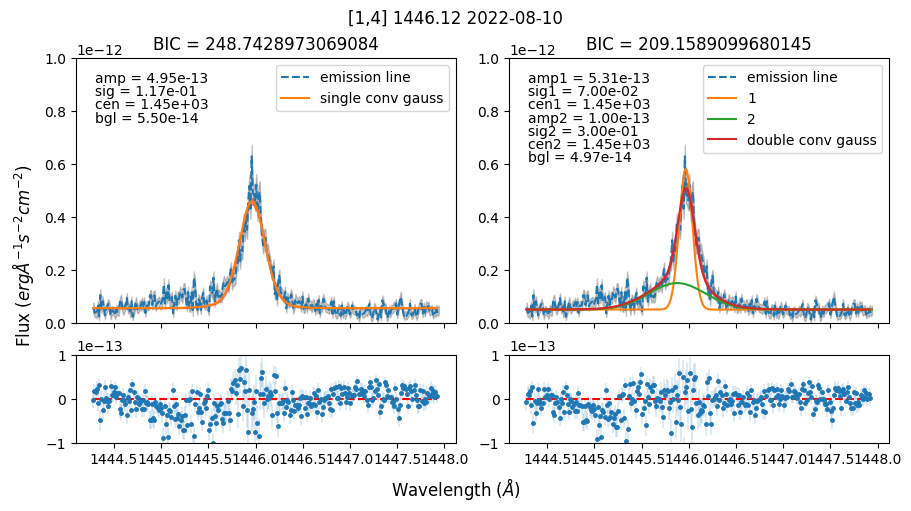

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


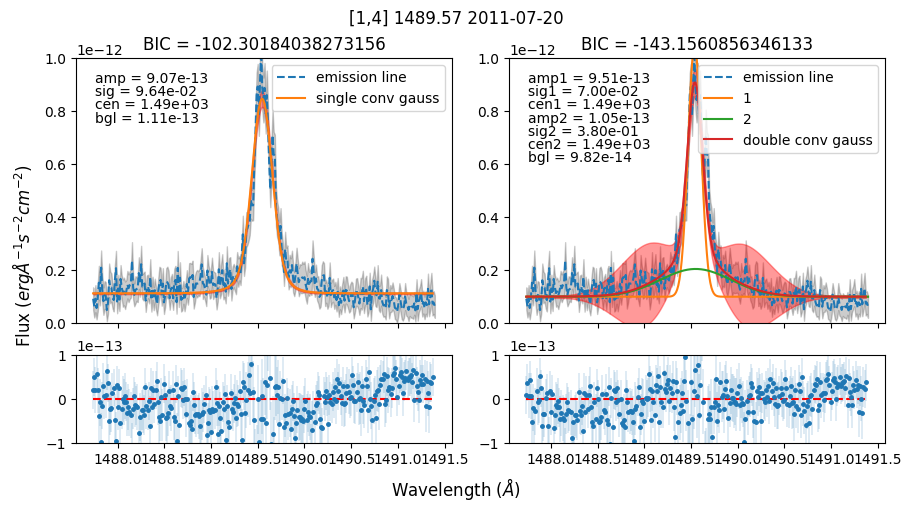

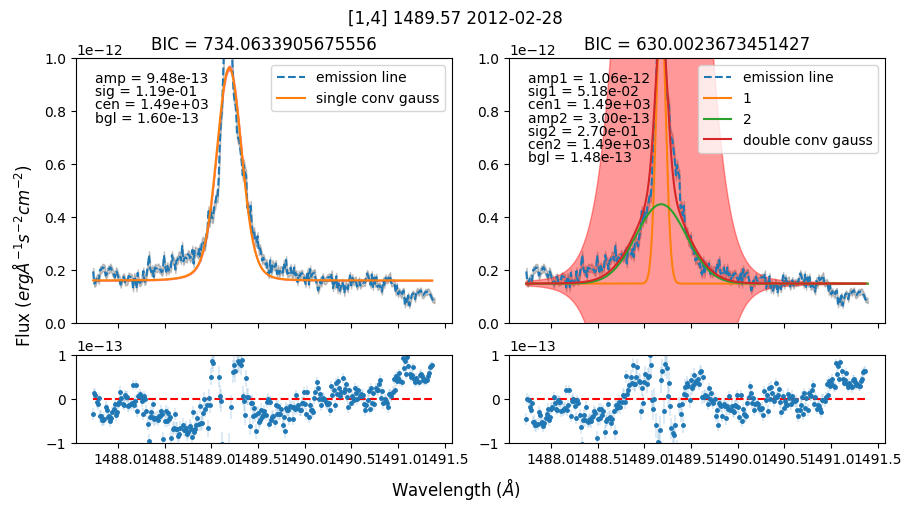

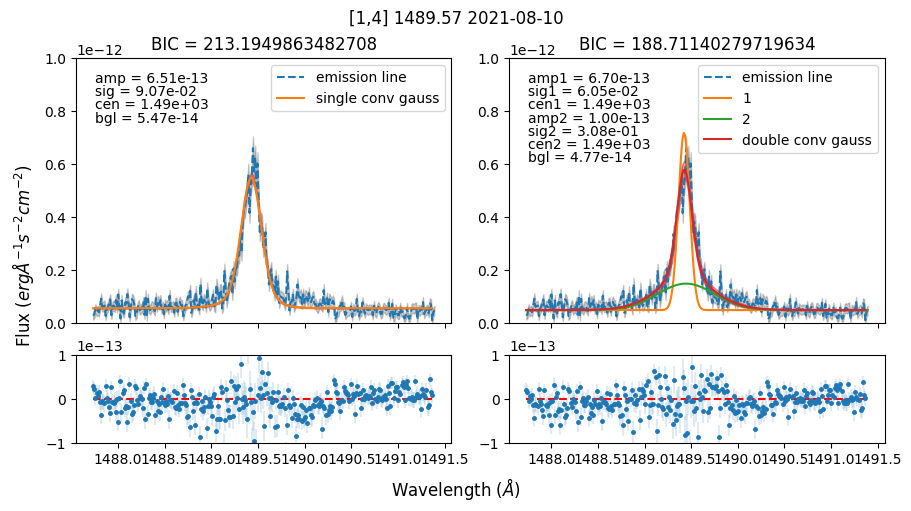

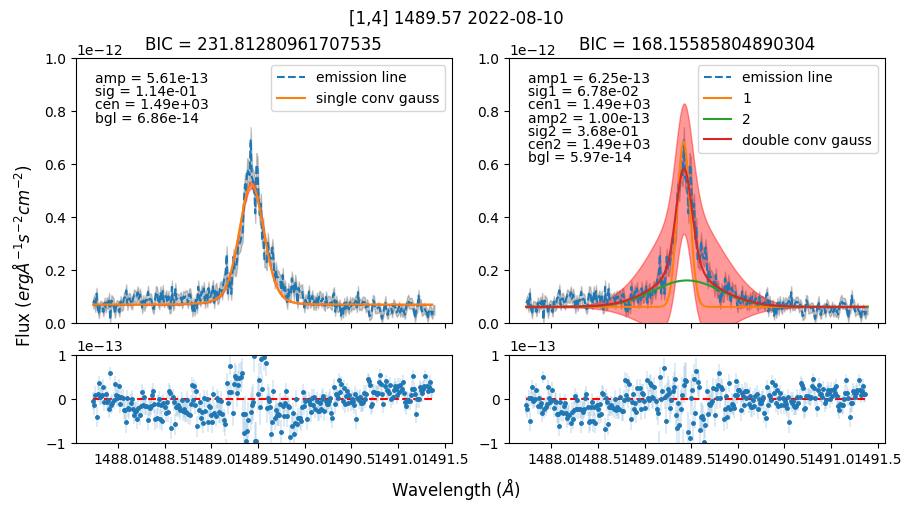

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


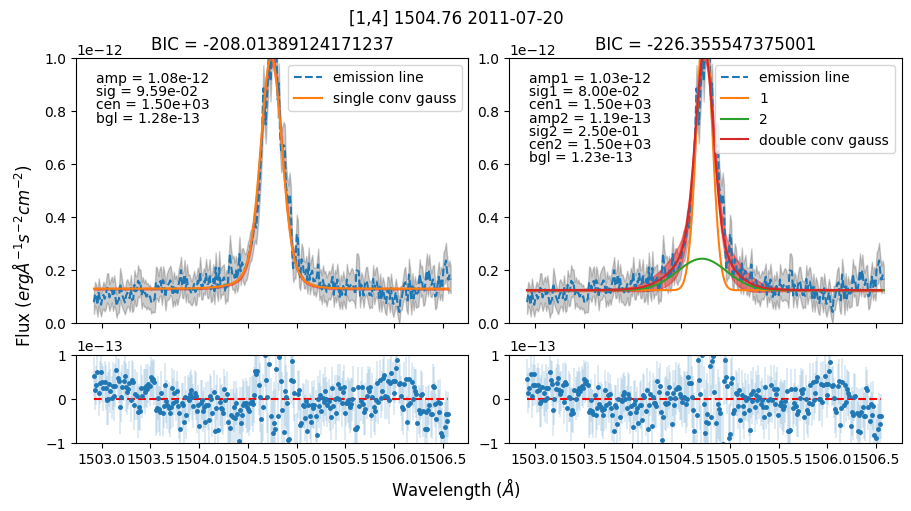

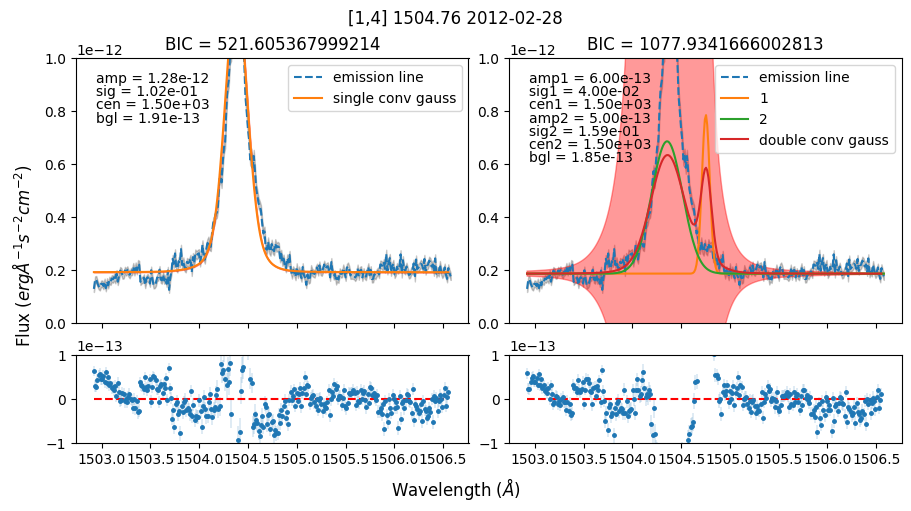

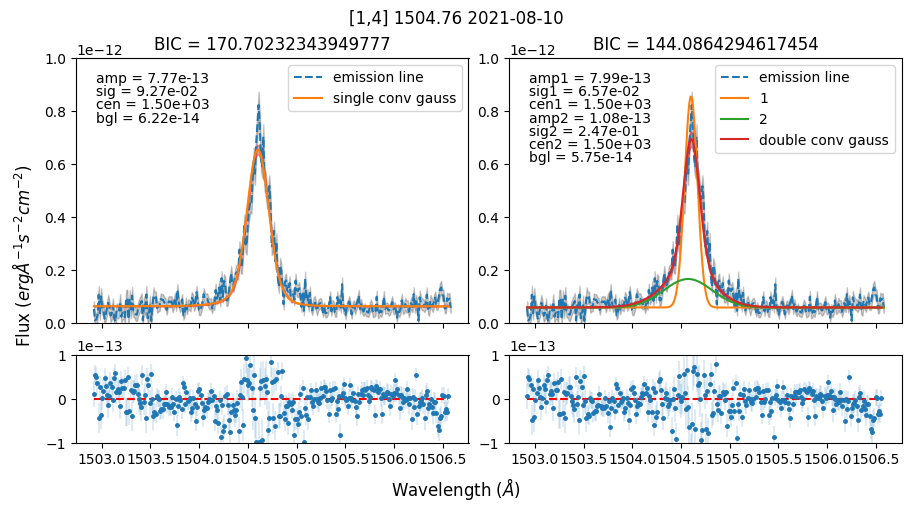

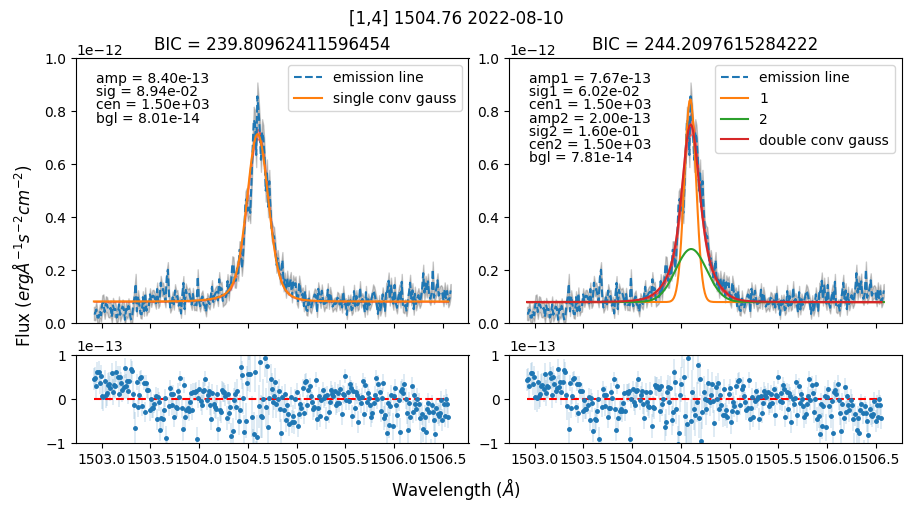

/tmp/ipykernel_5426/1353665827.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


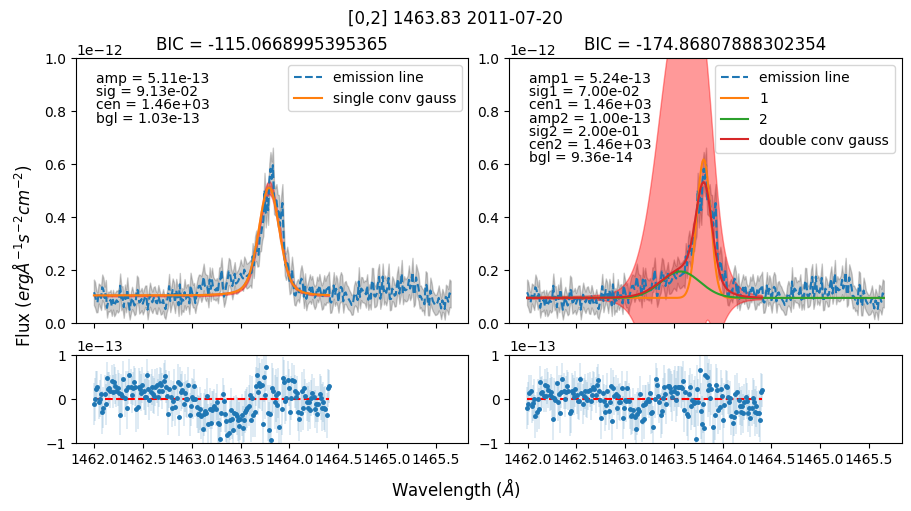

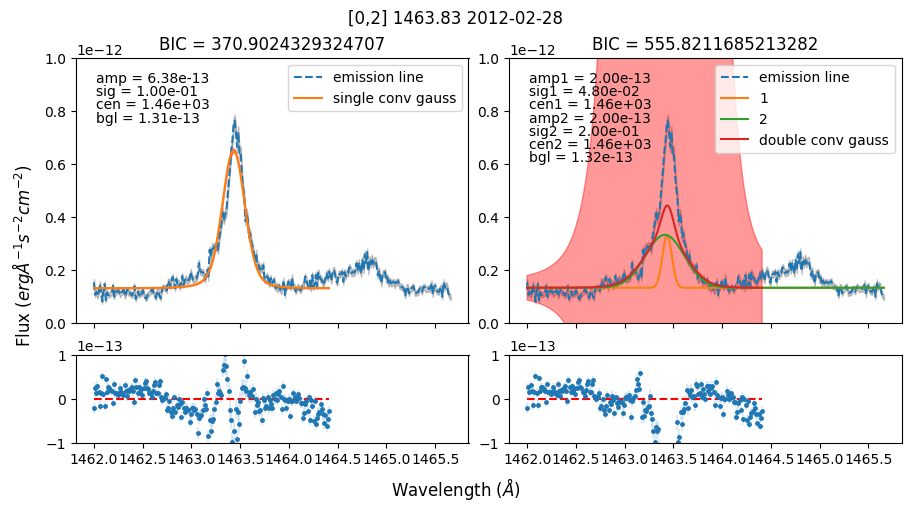

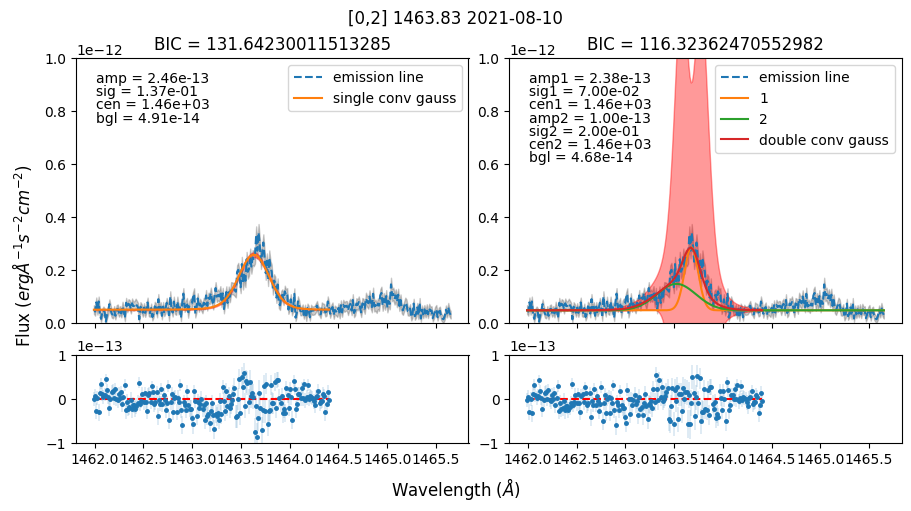

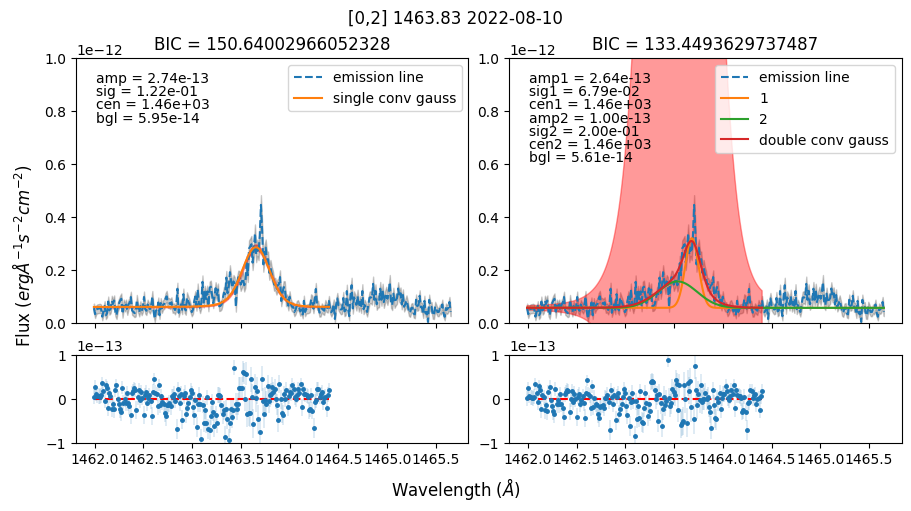

In [ ]:
#fits with initial guess
for line in line_df['labline'].unique():
    rest_wave = line
    test_df = pd.read_pickle(f'data/test_df_{rest_wave}.pkl')
    plot_fits(test_df, test_df['transition'].unique()[0], plot_vel=False)

/tmp/ipykernel_184122/2894244530.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)


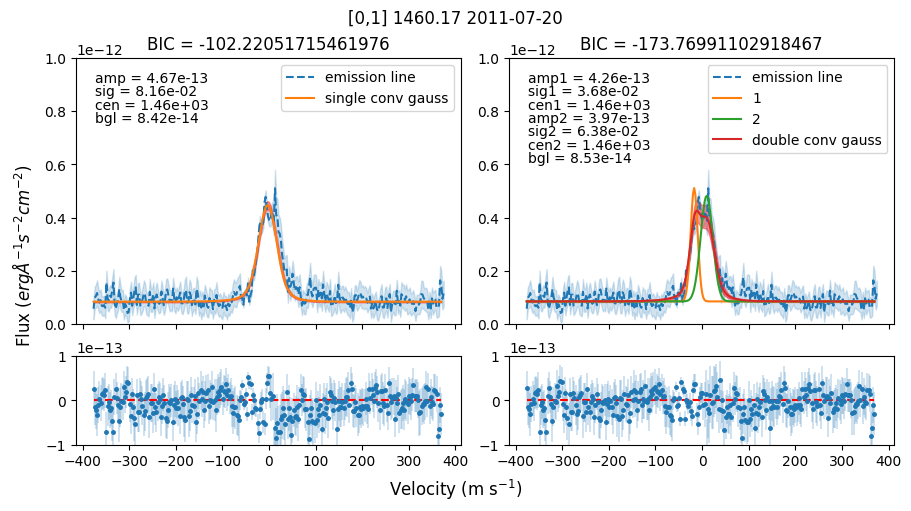

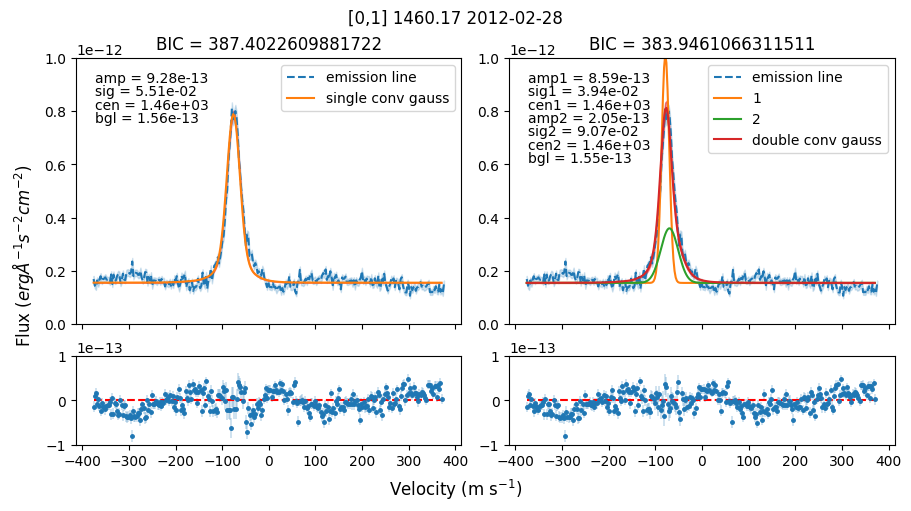

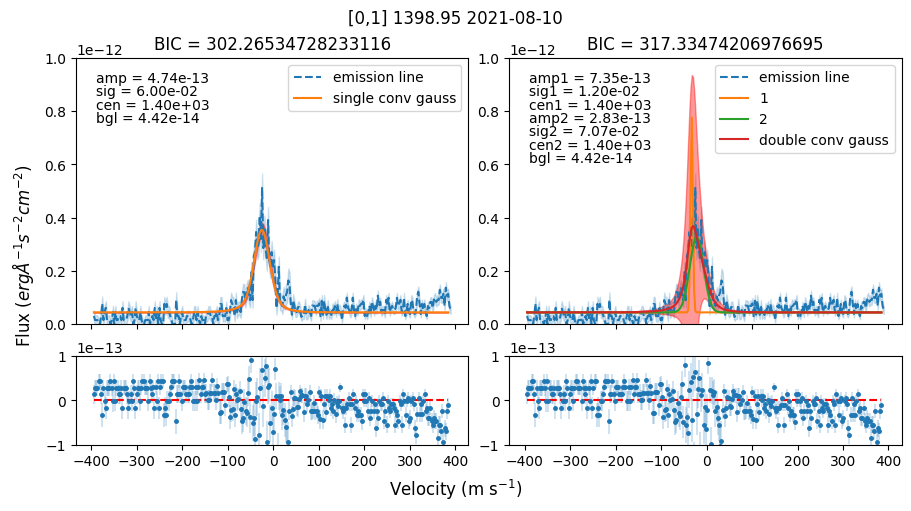

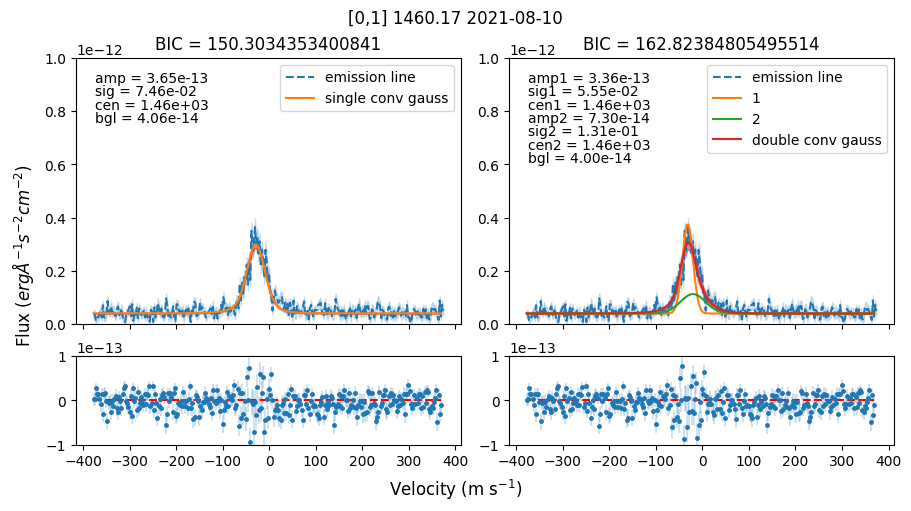

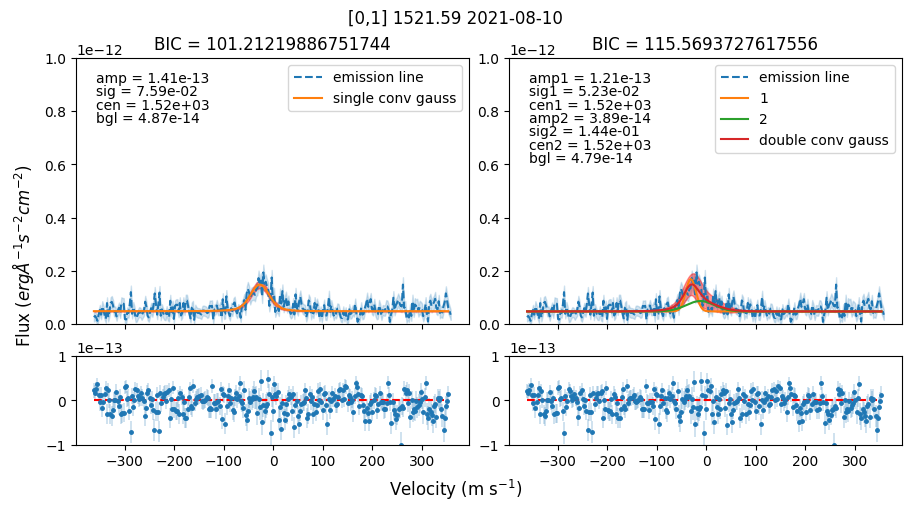

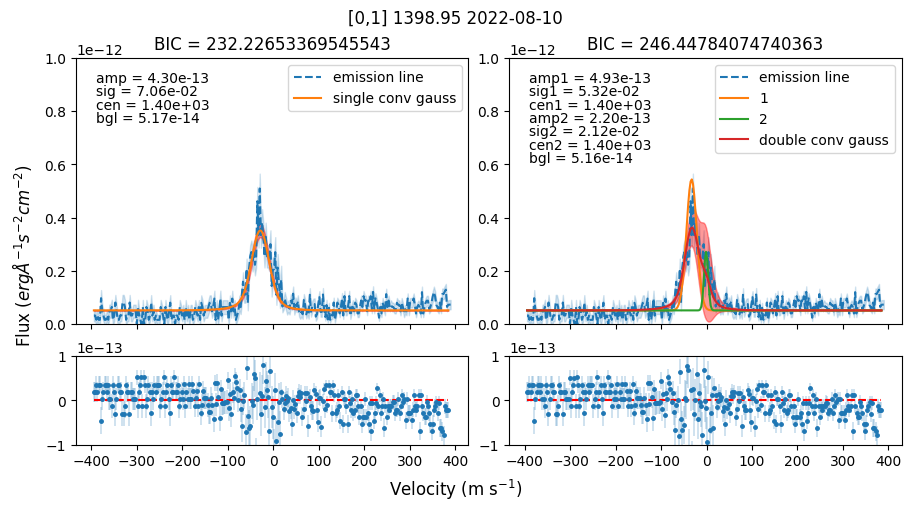

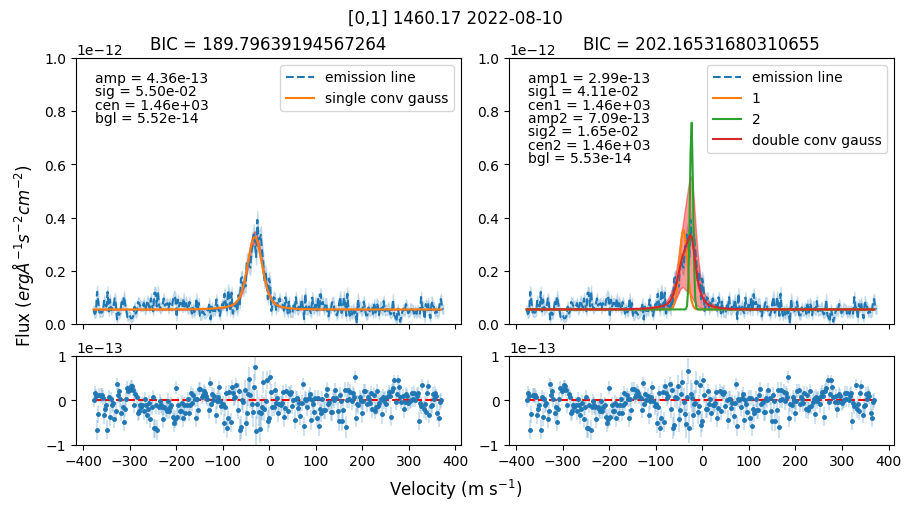

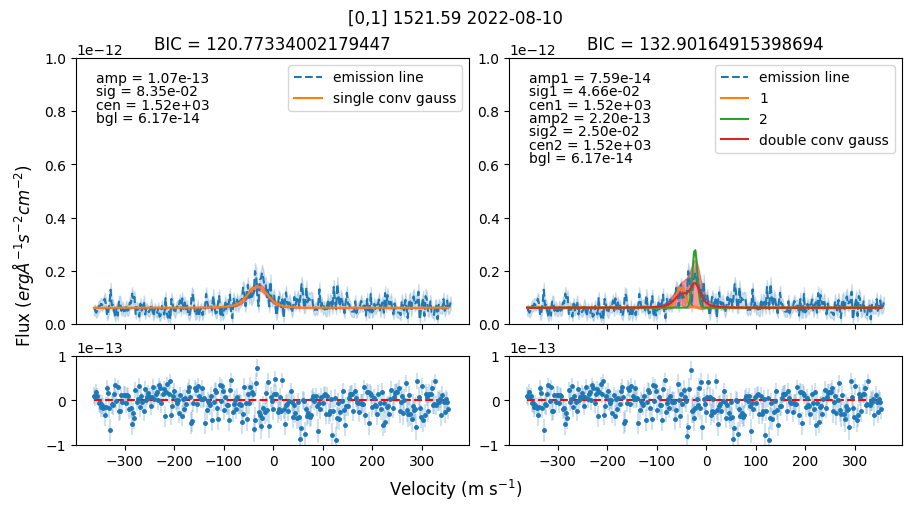

In [13]:
for transi in  line_df['transition'].unique()[:1]:
    plot_fits(line_df, transition=transi, plot_vel=True)

# Plot Coadded lines

In [ ]:
for transition_plot in ['[1,4]']:
    mask = prog_df['transition'] == transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
        fig.suptitle(row_prog['obsdate'] + ' ' + transition_plot)

        coadd_lines = line_df_cut[(line_df_cut['transition'] == transition_plot) & 
                              (line_df_cut['obsdate'] == row_prog['obsdate'])]

        #loop over original lines
        for _, row_line in coadd_lines.iterrows():
            velocity = radial_velocity(row_line['conv_wavelength'], row_line['labline'])

            # Single Gauss data
            ax[0, 0].plot(velocity, row_line['gauss_flux'], alpha=0.4, label=row_line['labline'])
            ax[0, 1].plot(velocity, row_line['gauss_flux']/row_line['gauss_fluxerr'], alpha=0.4)

            # Double Gauss data
            ax[1, 0].plot(velocity, row_line['double_gauss_flux'], alpha=0.4, label=row_line['labline'])
            ax[1, 1].plot(velocity, row_line['double_gauss_flux']/row_line['double_gauss_fluxerr'], alpha=0.4)

        #Single Gaussian Coadd
        ax[0, 0].plot(row_prog['coadded_velocity'], row_prog['single_coadded_flux'].value,
                      c='black', ls='--', lw=2, label='single coadd')
        ax[0, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['single_coadded_flux'].value-row_prog['single_coadded_fluxerr'].value,
                              row_prog['single_coadded_flux'].value+row_prog['single_coadded_fluxerr'].value,
                      color='black', alpha=0.3)
        ax[0, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[0, 1].plot(row_prog['coadded_velocity'],
                      row_prog['single_coadded_flux'].value / row_prog['single_coadded_fluxerr'].value,
                      c='black', ls='--', lw=2)

        # Double Gaussian Coadd
        ax[1, 0].plot(row_prog['coadded_velocity'], row_prog['double_coadded_flux'].value,
                      c='blue', ls='-', lw=2, label='double coadd')
        ax[1, 0].fill_between(row_prog['coadded_velocity'].value, row_prog['double_coadded_flux'].value-row_prog['double_coadded_fluxerr'].value,
                              row_prog['double_coadded_flux'].value+row_prog['double_coadded_fluxerr'].value,
                      color='blue', alpha=0.3)
        ax[1, 0].vlines(0, 0, 1.3e-12, 'r')
        ax[1, 1].plot(row_prog['coadded_velocity'],
                      row_prog['double_coadded_flux'].value / row_prog['double_coadded_fluxerr'].value,
                      c='blue', ls='-', lw=2)

        #Labels & Style
        for row in range(2):
            ax[row, 0].set_ylabel('Flux ' + u.format.Latex().to_string(row_prog['single_coadded_flux'].unit, fraction=False))
            ax[row, 0].set_ylim(0, 1e-12)
            ax[row, 0].set_xlim(-300, 300)
            ax[row, 0].legend(loc='lower right')
            ax[row, 0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}',
                            transform=ax[row, 0].transAxes, verticalalignment='top')

            ax[row, 1].set_ylabel('SNR')
            ax[row, 1].set_ylim(0, None)

        ax[1, 0].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))
        ax[1, 1].set_xlabel('Radial Velocity ' + u.format.Latex().to_string(row_prog['coadded_velocity'].unit, fraction=False))

        ax[0, 0].set_title('Single-Gaussian Coadd')
        ax[0, 1].set_title('Single-Gaussian SNR')
        ax[1, 0].set_title('Double-Gaussian Coadd')
        ax[1, 1].set_title('Double-Gaussian SNR')

        plt.tight_layout()
        plt.show()


# LSF shape
Plot the LSF shape over time for each emission line

In [22]:
lsf_df = pd.read_pickle('data/lsf_df.pkl')
disp_df = pd.read_pickle('data/disp_df.pkl')

In [23]:
def get_disp_params(disp_df, disptab, cenwave, filt, segment):
    data = disp_df.loc[disptab]
    wh_disp = np.where(
                (data["CENWAVE"] == cenwave)
                & (data["SEGMENT"] == segment)
                & (data["OPT_ELEM"] == filt)
            )[0]# 0 is needed as this returns nested list [[arr]]
    disp_coeff = data['COEFF'][wh_disp][0]# 0 is needed as this returns nested list [[arr]]
    d_tv03 = data["D_TV03"][wh_disp]  # Offset from WCA to PSA in Thermal Vac. 2003 data
    d_orbit = data["D"][wh_disp]  # Current offset from WCA to PSA
    delta_d = d_tv03 - d_orbit
    disp_coeff = disp_coeff-delta_d
    return disp_coeff

def redefine_lsf(lsf_df, disp_df, lsf_file, disptab, cenwave, filter, segment):
    """
    Helper function to convolve_lsf(). Converts the LSF kernels in the LSF file from a fn(pixel) -> fn(λ)\
    which can then be used by convolve_lsf() and re-bins the kernels.
    Parameters:
    lsf_file (str): path to your LSF file
    cenwave (str): Cenwave for calculation of dispersion relationship
    disptab (str): path to your DISPTAB file
    
    Returns:
    new_lsf (numpy.ndarray): Remapped LSF kernels.
    new_w (numpy.ndarray): New LSF kernel's LSF wavelengths.
    step (float): first order coefficient of the FUVA dispersion relationship; proxy for Δλ/Δpixel.
    """

    # Read in the dispersion relationship here for the segments
    if segment == 'FUVB':
        if (cenwave != 1105) & (cenwave != 800):
            disp_coeff = get_disp_params(disp_df, disptab, cenwave, filter, segment)
    else:
        disp_coeff = get_disp_params(disp_df, disptab, cenwave, filter, segment)

    # Get the step size info from the FUVA 1st order dispersion coefficient
    step = disp_coeff[1]

    # Read in the lsf file
    data = lsf_df.loc[lsf_file]
    lsf=data['lsf']
    pix=data['pix']
    w=data['w']

    # take median spacing between original LSF kernels
    deltaw = np.median(np.diff(w))

    if (deltaw < len(pix) * step * 2):  # resamples if the spacing of the original LSF wvlns is too narrow
        # this is all a set up of the bins we want to use
        # The wvln difference between kernels of the new LSF should be about twice their width
        new_deltaw = int(len(pix) * step * 2.0)  
        new_nw = (int(round((max(w) - min(w)) / new_deltaw)) + 1)  # nw = number of LSF wavelengths
        
        new_w = min(w) + np.arange(new_nw) * new_deltaw  # new version of lsf_wvlns
        
        # populating the lsf with the proper bins
        new_lsf = np.zeros((len(pix), new_nw))  # empty 2-D array to populate

        for i, current_w in enumerate(new_w):
            dist = abs(current_w - w)  # Find closest original LSF wavelength to new LSF wavelength
            lsf_index = np.argmin(dist)
            orig_lsf_wvln_key = lsf.keys()[lsf_index]  # column name corresponding to closest orig LSF wvln
            new_lsf[:, i] = np.array(lsf[orig_lsf_wvln_key])  # assign new LSF wvln the kernel of the closest original lsf wvln
    else:
        new_lsf = lsf
        new_w = w
    return new_lsf, new_w, step

In [ ]:
for labline in line_df_peak['labline'].unique():
    ws = []
    for i, row in line_df_peak[line_df_peak['labline']==labline].iterrows():
        lsf_file = row['LSFfile']
        disptab = row['dispfile']
        cenwave = row['cenwave']
        filt = row['filter']
        segment = row['segment']
        peak_wavelength = np.max(row['flux'].value)
        print(lsf_file, disptab, cenwave, filt, segment)
        new_lsf, new_w, _ = redefine_lsf(lsf_df, disp_df, lsf_file, disptab, cenwave, filt, segment)
        lsf_index = np.argmin(np.abs(new_w-peak_wavelength))
        ws.append(new_w[lsf_index])
        plt.plot(np.linspace(1, len(new_lsf[:,lsf_index]), len(new_lsf[:,lsf_index])), new_lsf[:,lsf_index])
    plt.title(f'{set(ws)} {labline}')
    plt.show()